# Replicating R-INLA results

## Joint density and its gradient and Hessian

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import scipy.stats
import scipy.optimize
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

import inla

nT = 50
n_i = np.full(4, nT)
x_i = np.array([0.0542217351633235, -0.7058565689642957, 0.5411263138456900, 1.1393884075711429])
p_i = np.array([0.5135521136895386, 0.3305150325484877, 0.6320743881220601, 0.7575673322021476])
y_i = np.array([28, 14, 33, 36]) * nT / 50
rinla_cis = np.array([
    [-0.2914459, 0.7714731],
    [-1.399438, -0.1621846],
    [0.05145177, 1.165792],
    [0.2554444, 1.437953]
])
data = np.stack((y_i[None, :], n_i[None, :]), axis=2)

In [27]:
# Qv is the value on the precision matrix diagonal. We can either treat Qv as
# known and infer the x_i via what would seem to be a purely frequentist maximum
# likelihood estimation. Or we can treat Qv as drawn from a prior distribution
# and infer the posterior distribution of both x_i and Qv.
def calc_precision_matrixQ(Qv):
    return np.diag(np.full(x_i.shape[0], Qv))

# Assume a normal prior for `a` centered at zero with variance 1 and a lognormal distribution for Qv with shape parameter 10.0.
def calc_log_prior(a, Qv):
    return scipy.stats.norm.logpdf(a, 0, 1) + scipy.stats.lognorm.logpdf(Qv, 10.0)

def calc_log_joint(x, y, n, a, Qv):
    Q = calc_precision_matrixQ(Qv)
    term1 = -(x-a).T.dot(Q).dot(x-a) / 2
    term2 = np.sum(x*y -n * np.log(np.exp(x) + 1))
    term3 = np.log(np.linalg.det(Q)) / 2
    term4 = calc_log_prior(a, Qv)
    return term1 + term2 + term3 + term4

def calc_log_joint_xonly(x, y, n, a, Qv):
    Q = calc_precision_matrixQ(Qv)
    term1 = -(x-a).T.dot(Q).dot(x-a) / 2
    term2 = np.sum(- n * np.log(np.exp(x) + 1))
    term3 = np.sum(x * y)
    return term1 + term2 + term3

def calc_gradx_log_joint(x, y, n, a, Qv):
    Q = calc_precision_matrixQ(Qv)
    term1 = -Q.dot(x - a)
    term2 = y - (n * np.exp(x) / (np.exp(x) + 1))
    return term1 + term2

def calc_hessx_log_joint(x, y, n, a, Qv):
    Q = calc_precision_matrixQ(Qv)
    term1 = -np.diag(n * np.exp(x) / ((np.exp(x) + 1) ** 2) )
    term2 = -Q
    return term1 + term2

In [29]:
def calc_x0_brute(av, Qv0):
    return scipy.optimize.minimize(
        lambda xvec: -calc_log_joint_xonly(xvec, y_i, n_i, av, Qv0),
        np.zeros_like(y_i),
        jac=lambda xvec: -calc_gradx_log_joint(xvec, y_i, n_i, av, Qv0),
        method='BFGS'
    )
calc_x0_brute(0.0, 1.0)['x'], x_i

(array([ 0.22307471, -0.86060795,  0.6094328 ,  0.86060795]),
 array([ 0.05422174, -0.70585657,  0.54112631,  1.13938841]))

In [32]:
import inla
model = inla.binomial_hierarchical()
inla.optimize_x0(model, data, np.array([[0.0, 1.0]]))['x']

array([ 0.22306184, -0.86057702,  0.6094032 ,  0.86057702])

In [5]:
qv0 = 1.0
dx = 0.001

def calc_numerical_grad(local_x_i, row):
    dx_vec = np.zeros(4)
    dx_vec[row] = dx
    f0 = calc_log_joint(local_x_i-dx_vec, y_i, n_i, 0, qv0)
    f2 = calc_log_joint(local_x_i+dx_vec, y_i, n_i, 0, qv0)
    f0_xonly = calc_log_joint_xonly(local_x_i-dx_vec, y_i, n_i, 0, qv0)
    f2_xonly = calc_log_joint_xonly(local_x_i+dx_vec, y_i, n_i, 0, qv0)
    
    # check that xonly is only dropping terms independent of x
    np.testing.assert_allclose(f2 - f0, f2_xonly - f0_xonly)
    return (f2 - f0) / (2*dx)

num_grad = np.empty(4)
for i in range(4):
    num_grad[i] = calc_numerical_grad(x_i, i)
analytical_grad = calc_gradx_log_joint(x_i, y_i, n_i, 0, qv0)

num_hess = np.empty((4, 4))
for i in range(4):
    for j in range(4):
        dx_vec = np.zeros(4)
        dx_vec[j] = dx
        g0 = calc_numerical_grad(x_i - dx_vec, i)
        g2 = calc_numerical_grad(x_i + dx_vec, i)
        num_hess[i, j] = (g2 - g0) / (2*dx)
np.set_printoptions(linewidth=100)
analytical_hess = calc_hessx_log_joint(x_i, y_i, n_i, 0, qv0)

np.testing.assert_allclose(num_grad, analytical_grad, atol=1e-5)
np.testing.assert_allclose(num_hess, analytical_hess, atol=1e-5)

In [7]:
analytical_grad

array([ 2.26817258, -1.81989506,  0.85515428, -3.01775502])

In [5]:
import scipy.integrate
x_mle = calc_x0_brute(0, 1.0)
for j in range(4):
    xj_vals = np.linspace(-2, 2, 200)
    x_vals = np.empty((200, 4))
    x_vals[:, :] = x_mle['x']
    x_vals[:, j] = xj_vals
    density_xj = np.array([np.exp(calc_log_joint_xonly(x_vals[i], y_i, n_i, 0, 1.0)) for i in range(x_vals.shape[0])])
    scaled = density_xj# / laplace_I
    # plt.plot(xj_vals, scaled)
    # plt.show()

    cdf = np.array([scipy.integrate.simpson(scaled[:i], xj_vals[:i]) for i in range(1, xj_vals.shape[0])])
    normalize = cdf[-1]
    cdf /= normalize

    # plt.plot(xj_vals[1:], cdf)
    # plt.show()
    ci = (xj_vals[np.argmax(cdf > 0.025) - 1], xj_vals[np.argmax(cdf > 0.975) + 1])
    print(f'x[{j}] ci here: {ci} \nr-inla ci: {rinla_cis[j]}  \ntrue val: {x_i[j]}\n')

x[0] ci here: (-0.31155778894472363, 0.7939698492462313) 
r-inla ci: [-0.2914459  0.7714731]  
true val: 0.0542217351633235

x[1] ci here: (-1.4974874371859297, -0.27135678391959805) 
r-inla ci: [-1.399438  -0.1621846]  
true val: -0.7058565689642957

x[2] ci here: (0.05025125628140703, 1.2160804020100504) 
r-inla ci: [0.05145177 1.165792  ]  
true val: 0.54112631384569

x[3] ci here: (0.29145728643216096, 1.4974874371859297) 
r-inla ci: [0.2554444 1.437953 ]  
true val: 1.139388407571143



## Finding the maximum of the joint density as a function of $x$


step 1: derive expression for hyperparameters:
\begin{align}
\log p(y, x, \theta) = \log p(x|\theta, y) + \log p(\theta|y) + \log p(y)\\
\log p(\theta | y) ~~ \propto ~~ \log p(y, x_0, \theta) - \log p(x_0|y, \theta)\\
\end{align}

step 2: laplace approximation for handling the latent variables
\begin{align}
f(x) \propto  \log p(y, x, \theta)\\
\log p(x_0 | y, \theta) = \log \big[ \frac{\exp [f(x_0)]}{LA(\int exp[f(x)] dx)} \big]\\
\log p(x_0 | y, \theta) = \log e^{f(x_0)} - \log LA(\int exp[f(x)] dx) \big]\\
\log p(x_0 | y, \theta) = \log e^{f(x_0)} - \log \big[ e^{f(x_0)} (2\pi)^{D/2}|-Hf(x_0))|^{-1/2} \big]\\
\log p(x_0 | y, \theta) = \log e^{f(x_0)} - \log e^{f(x_0)} - \log \big[(2\pi)^{D/2}\big] - \log \Big[|-Hf(x_0)|^{-1/2}\Big]\\
\log p(x_0 | y, \theta) = -(D/2)\log (2\pi) + \frac{1}{2}\log \Big[|-Hf(x_0)|\Big]\\
\end{align}

step 3: combine
\begin{align}
\log p(\theta | y) ~~ \propto ~~ \log p(y, x_0, \theta) + (D/2)\log (2\pi) - \frac{1}{2}\log \Big[|-Hf(x_0)|\Big]\\
\log p(\theta | y) ~~ \propto ~~ \log p(y, x_0, \theta) - \frac{1}{2} \log |-Hf(x_0)|
\end{align}

In [6]:
def calc_log_posterior_theta(a, Qv):
    x0_info = calc_x0_brute(a, Qv)
    detnegH = np.linalg.det(-calc_hessx_log_joint(x0_info['x'], y_i, n_i, a, Qv))
    ljoint = calc_log_joint(x0_info['x'], y_i, n_i, a, Qv)
    return ljoint - 0.5 * np.log(detnegH)

In [16]:
a_vals = np.linspace(-2, 2, 30)
q_vals = np.linspace(0.25, 10.0, 20)
AA, QQ = np.meshgrid(a_vals, q_vals)

logpost = np.array([[calc_log_posterior_theta(av, qv) for av in a_vals] for qv in q_vals])
logpost -= np.mean(logpost)
post_theta = np.exp(logpost)
post_theta_normalization = scipy.integrate.simpson(scipy.integrate.simpson(post_theta, a_vals), q_vals)
post_theta /= post_theta_normalization
# print(a_vals[np.argmax(logpost)])

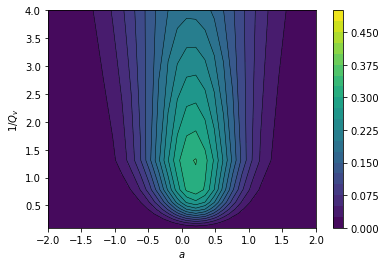

In [17]:
levels=np.linspace(0, 0.5, 21)
cntf = plt.contourf(AA, 1/QQ, post_theta.reshape(AA.shape), levels=levels)
plt.contour(
    AA, 1/QQ, post_theta.reshape(AA.shape),
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels
)
cbar = plt.colorbar(cntf)
plt.xlabel('$a$')
plt.ylabel('$1/Q_v$')
plt.show()

In [18]:
idx = np.unravel_index(np.argmax(logpost), logpost.shape)
map_hyperparams = AA[idx], 2 ** QQ[idx]
map_hyperparams

(0.2068965517241379, 1.6972015422681888)

## Posterior of the latent variables
$$p(x|y) = \int p(x|y,\theta) p(\theta | y) d\theta$$

In [20]:
1000 ** 0.25

5.623413251903491

x[0] ci here: (-0.30508474576271194, 0.847457627118644) 
r-inla ci: [-0.2914459  0.7714731]  
true val: 0.0542217351633235

0.23728813559322015


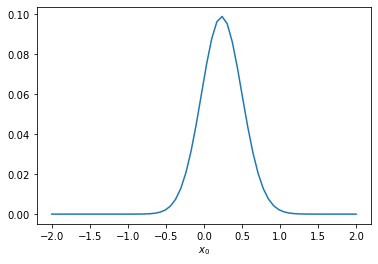

x[1] ci here: (-1.3898305084745761, -0.10169491525423724) 
r-inla ci: [-1.399438  -0.1621846]  
true val: -0.7058565689642957

-0.7118644067796611


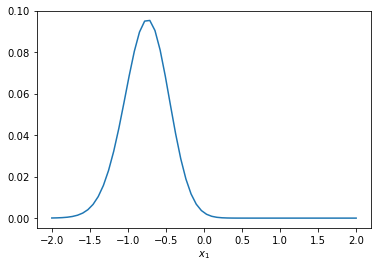

x[2] ci here: (0.03389830508474567, 1.2542372881355934) 
r-inla ci: [0.05145177 1.165792  ]  
true val: 0.54112631384569

0.5762711864406778


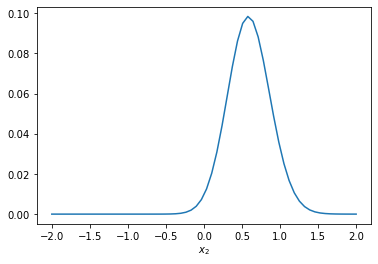

x[3] ci here: (0.23728813559322015, 1.5254237288135593) 
r-inla ci: [0.2554444 1.437953 ]  
true val: 1.139388407571143

0.7796610169491527


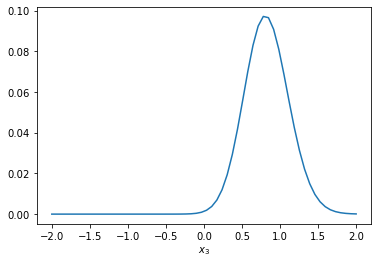

In [109]:
def calc_px_given_ytheta(xj, j, a, Qv):
    # laplace approximation of denomiator/scaling
    x0_info = calc_x0_brute(a, Qv)
    detnegH = np.linalg.det(-calc_hessx_log_joint(x0_info['x'], y_i, n_i, a, Qv))
    laplace_I = np.exp(-x0_info['fun']) * ((2 * np.pi) ** (y_i.shape[0] / 2)) / np.sqrt(detnegH)

    x = x0_info['x'].copy()
    x[j] = xj
    density_x = calc_log_joint(x, y_i, n_i, a, Qv)
    scaled = np.exp(density_x) / laplace_I
    return scaled

xj_vals = np.linspace(-2, 2, 60)
for j in range(4):
    px_given_ytheta = np.array([[[calc_px_given_ytheta(xv, j, av, qv) for xv in xj_vals] for av in a_vals] for qv in q_vals])

    post_x_terms = px_given_ytheta * post_theta[:,:,None]
    post_x = scipy.integrate.simpson(scipy.integrate.simpson(post_x_terms, q_vals, axis=0), a_vals, axis=0)
    cdf = np.array([scipy.integrate.simpson(post_x[:i], xj_vals[:i]) for i in range(1, xj_vals.shape[0])])
    normalize = cdf[-1]
    cdf /= normalize
    ci = (xj_vals[np.argmax(cdf > 0.025) - 1], xj_vals[np.argmax(cdf > 0.975) + 1])
    print(f'x[{j}] ci here: {ci} \nr-inla ci: {rinla_cis[j]}  \ntrue val: {x_i[j]}\n')
    print(xj_vals[np.argmax(post_x)])
    plt.plot(xj_vals, post_x)
    # plt.ylabel('$$')
    plt.xlabel(f'$x_{j}$')
    plt.show()